In [1]:
## Updated 1-7-25

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from joblib import dump
import time
import unsupervised_scripts
import processing



### TRAIN MODEL

## Initialize start and end of hyperspectral sweep; num_samp is calculated from image stack
wavenum_1 = int(input('Enter first wavenumber/higher wavelength (Default=2700)): ').strip() or '2700')
wavenum_2 = int(input('Enter last wavenumber/lower wavelength (Default=3100): ').strip() or '3100')
num_samp = int(input('Enter HSI step size: ').strip()) 
ch_start = int(np.floor(num_samp/((wavenum_2-wavenum_1)/(2800-wavenum_1))))
background_df = pd.read_csv('water_HSI_76.csv')
molecule_df = pd.read_excel('lipid_subtype.xlsx')
shift = 20

## Training Directory (different for everyone)
path_dir = ''
data_dir = os.getcwd()+'/'
sample_dir = data_dir + 'training_data/'+str(num_samp)+'-'+str(wavenum_1)+'-'+str(wavenum_2)+'/'

artificial_dataset = unsupervised_scripts.artificial_dataset(wavenum_1, wavenum_2, num_samp, ch_start, background_df, shift)
[image_vec, _, _,_] = artificial_dataset.save_srs_params(sample_dir)
[mol_norm, mol_names] = artificial_dataset.molecule_dataset(molecule_df)

## Load artificial dataset
X_data = np.load('artificial_data/artificial_training_data-'+str(wavenum_1)+'_'+str(wavenum_2)+'_'+str(num_samp)+'.npy')
Y = list(range(len(mol_names)))*len(X_data)
X = np.reshape(np.transpose(X_data, (1, 0, 2)), (X_data.shape[0] * X_data.shape[1], X_data.shape[2]), order='F')


## Process both datasets
preprocessing = unsupervised_scripts.preprocessing(wavenum_1, wavenum_2, num_samp, ch_start, background_df)
X_norm  = preprocessing.spectral_standardization(np.flip(X,axis=1))
image_norm = preprocessing.spectral_standardization(image_vec, br_shift=shift)
# X_norm = processing.normalize(X_norm, max=np.max(image_norm))
# X_norm = (X_norm.T-np.median(X_norm[:ch_start])).T

100%|██████████| 9/9 [00:00<00:00, 24.90it/s]


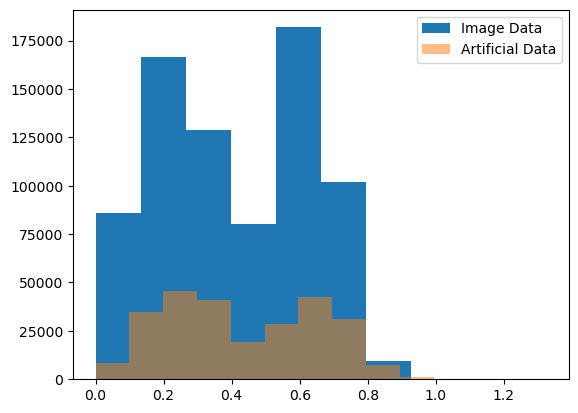

In [2]:
plt.hist(np.max(image_norm,axis=1)-image_norm[:,0], label='Image Data')
plt.hist(np.max(X_norm, axis=1)-X_norm[:,0],alpha=0.5, label='Artificial Data')
plt.legend()

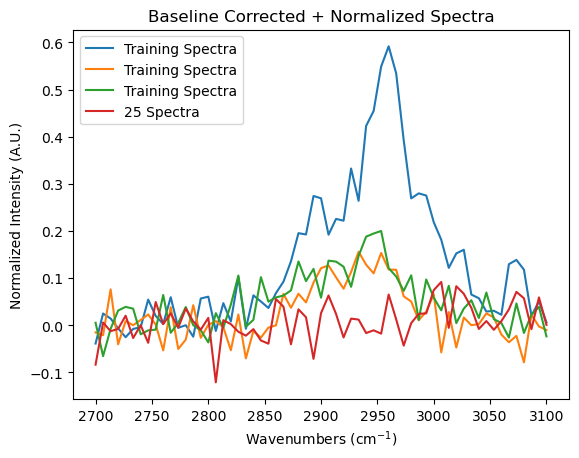

In [3]:
## Visualize random spectra for validation of preprocessing

wavenumbers = np.linspace(wavenum_1, wavenum_2, num_samp)
indeces = [random.randint(0, image_norm.shape[0] - 1), random.randint(0, image_norm.shape[0] - 1),
               random.randint(0, image_norm.shape[0] - 1)]
plt.plot(wavenumbers, image_norm[indeces].T, label='Training Spectra')
rand_idx = np.random.randint(0, X_norm.shape[0])
plt.plot(wavenumbers, X_norm[rand_idx].T, label=f'{Y[rand_idx]} Spectra')
plt.legend()
plt.title('Baseline Corrected + Normalized Spectra')
plt.xlabel('Wavenumbers (cm$^{-1}$)')
plt.ylabel('Normalized Intensity (A.U.)')
plt.show()

In [4]:
## No smoothing (OPTIONAL)
x = image_norm
X = X_norm
smooth = 'No Smoothing'

In [6]:
## Train Random Forest Classifier
start_time = time.time()
rf_classifier = unsupervised_scripts.RF_classify(x, X, Y, .25)
num_estimators = int(input('Enter number of estimators: ') or '250')
rfc = rf_classifier.train(num_estimators=num_estimators, criterion='gini')
dump(rfc, 'rf_classifiers/rfc-'+smooth+'_'+str(wavenum_1)+'_'+str(wavenum_2)+'_'+str(num_samp)+'_'+str(num_estimators)+'.joblib')
end_time = time.time()
execution_time = end_time - start_time
print(f" Training Finished \n Execution time: {execution_time} seconds")

 Training Finished 
 Execution time: 157.88091611862183 seconds
